## Analysis of EVI Trend Break Magnitudes with XGBRegressor - v5

Peter R., 2023-08-24

### Intro
There are several way to carry our Extreme Gradient Boosting (XGB). You could use R or Python.  There are several R packages to do XGB such as "dismo" and "xgboosting". In Python there are several ways as well. You can do XGB with the sklearn framework and within this framework you can use train(), XGBClassifier(), XGBRegressor() etc.  Here I use XGBRegression() to analyze forest EVI breaks (both negative & positive breaks) together.

Here I try to answer the question: What factors predict EVI (negative and positive) Trend Break magnitude?

Note that driver data have been assigned here by using spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data.  An important missing driver is likely tree windthrow.

In this version of my code, I am using year as a categorical variable. (Note: no sig. improvement seen)

In this version, I will split negative and positive breaks. Also, I have included moisture (cmi) and relative humity (rh) variables.  I have removed lat, lon, and drivers variables.

#### File and folder path settings

In [1]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\github\forc_trends\models\xgboost


#### Load and explore the data

In [2]:
import pandas as pd
#from pandas import read_csv
from numpy import nan

df1 = pd.read_csv(r'.\data\forest_evi_breaks_sam3.csv', skipinitialspace=True)
df1.head()


year  magnitude    age  deciduous  conifers  protected  elevation  \
0  2021        915  77.62      89.11     10.19          0        519   
1  2014       -796  82.34      84.63     15.32          0        455   
2  2013       -440  83.74      72.48     27.19          0        453   
3  2010       -937  62.46      84.37     15.56          0        486   
4  2009        577  73.38      64.01     33.89          1        224   

   precipitation  temperature  precipitation_lag1  ...  precipitation_lag3  \
0         1031.0         5.70                1155  ...                1098   
1         1135.0         2.70                1160  ...                1004   
2         1172.0         3.44                 981  ...                 970   
3          970.0         5.41                1056  ...                 885   
4          876.0         4.06                 973  ...                 983   

   temperature_lag3   cmi    rh  cmi_lag1  rh_lag1  cmi_lag2  rh_lag2  \
0              4.19  49.1  60.0      65.3     61.0      76.2     59.0   
1              4.49  66.8  60.0      66.2     60.0      41.5     61.0   
2              5.22  67.6  61.0      42.5     61.0      48.6     62.0   
3              4.05  44.1  63.0      60.0     60.0      69.4     59.0   
4              5.64  37.4  58.0      44.8     57.0      25.9     57.0   

   cmi_lag3  rh_lag3  
0      58.3     61.0  
1      47.8     61.0  
2      44.9     63.0  
3      34.3     59.0  
4      43.4     60.0  

[5 rows x 23 columns]

In [2]:
#df1.tail()

In [3]:
# note: in this test data set, protected has a single value. Hence, get_dummies does not work as expected
df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)
#df2 = pd.get_dummies(df1, columns=['year', 'protected'], dtype=float)

#df2.head()


In [5]:
#print(df2.describe)

# Remove records where precipitation is null
df2= df2[df2['precipitation'].notna()]
#print(df2.describe)
#[788 rows x 24 columns]

In [10]:
#df2.tail()

#pd.to_numeric(df2)

# check data types
print(df2.dtypes)


year                    int64
magnitude               int64
age                   float64
deciduous             float64
conifers              float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
cmi                   float64
rh                    float64
cmi_lag1              float64
rh_lag1               float64
cmi_lag2              float64
rh_lag2               float64
cmi_lag3              float64
rh_lag3               float64
protected_0           float64
protected_1           float64
dtype: object


In [61]:
# split data into input and output columns
#from numpy import absolute

X1 = df2.iloc[:,2:24]
# conifers & deciduous are highly negatively correlated. I drop conifers
# Also, precipitation is correlated with CMI. I will drp cmi, cmi_lag1, cmi_lag2, cmi_lag3.
X1.drop(X1.columns[[2, 12, 14, 16, 18]], axis=1,inplace=True)
print(X1.head())

#df[list(df.columns[:2]) + [7]]

#print(X1.describe)
#print(X1.dtypes)



     age  deciduous  elevation  precipitation  temperature  \
0  77.62      89.11        519         1031.0         5.70   
1  82.34      84.63        455         1135.0         2.70   
2  83.74      72.48        453         1172.0         3.44   
3  62.46      84.37        486          970.0         5.41   
4  73.38      64.01        224          876.0         4.06   

   precipitation_lag1  temperature_lag1  precipitation_lag2  temperature_lag2  \
0                1155              5.01                1233              3.00   
1                1160              3.34                 973              5.34   
2                 981              5.50                1010              4.60   
3                1056              3.51                1167              3.70   
4                 973              4.24                 844              4.56   

   precipitation_lag3  temperature_lag3    rh  rh_lag1  rh_lag2  rh_lag3  \
0                1098              4.19  60.0     61.0     59.0 

In [57]:
# I will run a correlation plot with X2
X2 = X1

X2.drop(X2.columns[[15,16]], axis=1,inplace=True)
#print(X2.describe)
print(X2.dtypes)


age                   float64
deciduous             float64
elevation               int64
precipitation         float64
temperature           float64
precipitation_lag1      int64
temperature_lag1      float64
precipitation_lag2      int64
temperature_lag2      float64
precipitation_lag3      int64
temperature_lag3      float64
rh                    float64
rh_lag1               float64
rh_lag2               float64
rh_lag3               float64
dtype: object


In [53]:
y1 = df2.iloc[:,1]
print("Response/label data")
print(y1.head())

#print("Response/label data, Absolute value of Negative break magnitude")
#y2 = absolute(y1)
#print(y2.head())

#X, y = df2[:, :-1], df2[:, -1]
#X.head()

Response/label data
0    915
1   -796
2   -440
3   -937
4    577
Name: magnitude, dtype: int64


In [64]:
#print(X1.head())

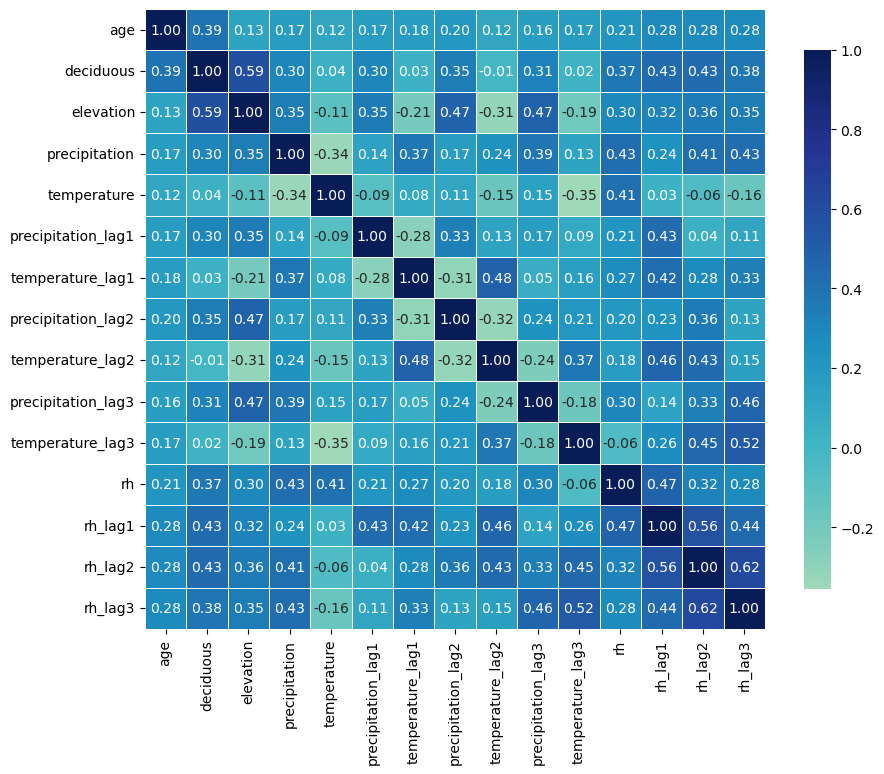

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

#def correlation_heatmap(X1):
#    correlations = X1.corr()
    
def correlation_heatmap(X2):
    correlations = X2.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )

    #plt.show();

#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3","protected_0","protected_1",
#                 "cmi", "rh" ,"cmi_lag1", "rh_lag1","cmi_lag2", "rh_lag2","cmi_lag3", "rh_lag3"]

features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

correlation_heatmap(X1[features_names1])
# sorted_idx = xgb.feature_importances_.argsort()

plt.savefig('correlation5.png',  dpi=300, bbox_inches='tight')


plt.show()

In [62]:
#print(X1.head())

     age  deciduous  elevation  precipitation  temperature  \
0  77.62      89.11        519         1031.0         5.70   
1  82.34      84.63        455         1135.0         2.70   
2  83.74      72.48        453         1172.0         3.44   
3  62.46      84.37        486          970.0         5.41   
4  73.38      64.01        224          876.0         4.06   

   precipitation_lag1  temperature_lag1  precipitation_lag2  temperature_lag2  \
0                1155              5.01                1233              3.00   
1                1160              3.34                 973              5.34   
2                 981              5.50                1010              4.60   
3                1056              3.51                1167              3.70   
4                 973              4.24                 844              4.56   

   precipitation_lag3  temperature_lag3    rh  rh_lag1  rh_lag2  rh_lag3  \
0                1098              4.19  60.0     61.0     59.0 

#### Set up & run model

Here the model evaluation metric is mean absoulte error. Other metrics are available for regression.


In [65]:
# evaluate an xgboost regression model on the housing dataset
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

print("XGB version:", xgb.__version__)

# split data into input and output columns
#X, y = df2[:, :-1], df2[:, -1]

seed = 7 # random seed to help with replication
testsize1 = 0.2 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

# set custom parameters rather than use defaults
# 'reg:linear', reg:squarederror
param = {
    'max_depth': 4,  # tree complexity, tree depth
    'eta':0.3,  # learning rate
    'objective': 'reg:squarederror'  #minimize sqaured error
   
}

#epochs = 10 # no longer needed, used with train()


# define model
model_m2a = XGBRegressor(set_params=param)

# n_estimators is the number of trees
print(model_m2a)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) # 289.996 (52.529), Mean MAE: 288.345 (51.031); Mean MAE: 561.678 (63.102)
# 543.457 (58.644)
# 537.123 (69.883)

XGB version: 1.7.6
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Mean MAE: 529.372 (69.402)


In [66]:
# evaluate model with mean square error
scores2 = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores2 = absolute(scores)
print('Mean MSE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) ) # Mean MSE: 289.996 (52.529); 288.345 (51.031); Mean MSE: 577.740 (58.160), Mean MSE: 561.678 (63.102)

# Mean MSE: 543.457 (58.644)
# Mean MSE: 537.123 (69.883)



Mean MSE: 529.372 (69.402)


In [67]:
#import statistics

# evaluate model with variance explained
scores3 = cross_val_score(model_m2a, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.102 (0.466)

#Mean Var. Explained: 0.091 (0.130)
#Mean Var. Explained: 0.110 (0.160)
    

Mean Var. Explained: 0.139 (0.154)


In [68]:
# R-squared
# evaluate model with variance explained
scores4 = cross_val_score(model_m2a, x1_train, y1_train, scoring='r2', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('R-sq: %.3f (%.3f)' % (scores4.mean(), scores4.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.102 (0.466)

#R-sq: 0.076 (0.136)
# R-sq: 0.097 (0.162)



R-sq: 0.127 (0.153)


#### Fine tunning parameters
Fine tune parameters to find a better model (potentially). 

In [69]:
# Fine tune parameters using GridSearchCV (for exhaustive searches) or RandomizedSearchCV (faster)
# max_depth is tree complexity in Elith et al. 2008
# n_estimators=100 is the number of trees. Elith et al. 2008 say this should be 1000 at least
# Elith et al. 2008 suggests low learning rate

# Take 1
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.01, 0.05, 0.10, 0.15],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [ 3, 4, 5, 6],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "gamma"            : [ 0.0, 0.05, 0.1, 0.25],
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2b = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2b, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=10, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train), 

random_search.best_estimator_



C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 64 candidates, totalling 320 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [70]:
# Optimal model according to random search above

model_m2c = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)


#print(model_m2c)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2c, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# with fire, harv, ins nulls: Mean MAE: 566.434 (51.825)
# Mean MAE: 556.860 (56.363), 555.873 (55.005); 526.198 (64.718)

# Mean MAE: 527.065 (60.386)
# Mean MAE: 511.496 (61.699)



Mean MAE: 526.682 (68.147)


In [71]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2c, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.145 (0.423)
# nulls: Mean Var. Explained: 0.206 (0.116)
# Mean Var. Explained: 0.192 (0.121); 0.194 (0.125)
# Mean Var. Explained: 0.160 (0.105)
# Mean Var. Explained: 0.183 (0.113)



Mean Var. Explained: 0.143 (0.132)


In [72]:
# Take 2
# Given that learning_rate and max_depth were at the their upper limit I ran RandomizedSearchCV with expanded values
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.15, 0.20, 0.25],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [5, 6, 7],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 #"gamma"            : [ 0.0, 0.25 , 1.0 ], # 0.25 was chosen
 "gamma"            : [ 0.0, 0.001, 0.01], # 0.0 was chosen
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2d = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2d, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=1, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train)

random_search.best_estimator_

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [73]:
# Optimal model according to random search. early_stopping_rounds conflicts with cross_val_score
model_m2e = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)

# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
#scores = cross_val_score(model_m2e, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) #Mean MAE: 555.691 (50.281)
#Mean MAE: 566.044 (56.495); 526.541 (62.535)

# Mean MAE: 527.065 (60.386)
# Mean MAE: 511.496 (61.699)

Mean MAE: 526.682 (68.147)


In [74]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2e, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)
# Variance explained is more than model_m2c. Model_m2d seems better.
# nulls out: Mean Var. Explained: 0.218 (0.121), model_m2c explain more
# Mean Var. Explained: 0.186 (0.114)


Mean Var. Explained: 0.143 (0.132)


#### Evaluation

In [75]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_m2e.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model_m2e.predict(x1_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y1_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model_m2e.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
#x_axis = range(0, 100)


[0]	validation_0-error:-655.34444	validation_0-logloss:-27204.11126	validation_1-error:-361.92405	validation_1-logloss:-15014.22572
[1]	validation_0-error:-669.19048	validation_0-logloss:-28170.66920	validation_1-error:-382.52532	validation_1-logloss:-16068.52969
[2]	validation_0-error:-672.39841	validation_0-logloss:-28541.28682	validation_1-error:-359.63291	validation_1-logloss:-15351.01247
[3]	validation_0-error:-678.02540	validation_0-logloss:-28935.14597	validation_1-error:-379.13924	validation_1-logloss:-16232.74732
[4]	validation_0-error:-697.01905	validation_0-logloss:-29814.62165	validation_1-error:-395.68987	validation_1-logloss:-16908.65783
[5]	validation_0-error:-706.50635	validation_0-logloss:-30354.23828	validation_1-error:-362.42405	validation_1-logloss:-15847.50797
[6]	validation_0-error:-705.63968	validation_0-logloss:-30323.43481	validation_1-error:-366.89241	validation_1-logloss:-15858.11853
[7]	validation_0-error:-716.02698	validation_0-logloss:-30808.38332	validati

[62]	validation_0-error:-822.71746	validation_0-logloss:-35825.49286	validation_1-error:-367.64557	validation_1-logloss:-16033.20963
[63]	validation_0-error:-824.71905	validation_0-logloss:-35904.92204	validation_1-error:-367.64557	validation_1-logloss:-16027.93909
[64]	validation_0-error:-824.71905	validation_0-logloss:-35912.98767	validation_1-error:-367.64557	validation_1-logloss:-16034.30678
[65]	validation_0-error:-825.56508	validation_0-logloss:-35950.05680	validation_1-error:-363.18354	validation_1-logloss:-15865.27388
[66]	validation_0-error:-827.77619	validation_0-logloss:-36043.21857	validation_1-error:-363.18354	validation_1-logloss:-15870.45196
[67]	validation_0-error:-827.77619	validation_0-logloss:-36045.65984	validation_1-error:-363.18354	validation_1-logloss:-15870.32040


C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-error:-832.10317	validation_0-logloss:-36191.30645	validation_1-error:-367.64557	validation_1-logloss:-16032.26077
[69]	validation_0-error:-832.10317	validation_0-logloss:-36192.81672	validation_1-error:-367.64557	validation_1-logloss:-16032.61600
[70]	validation_0-error:-832.10317	validation_0-logloss:-36227.76762	validation_1-error:-367.64557	validation_1-logloss:-16039.96398
[71]	validation_0-error:-832.10317	validation_0-logloss:-36231.06178	validation_1-error:-363.18354	validation_1-logloss:-15867.21711
[72]	validation_0-error:-832.10317	validation_0-logloss:-36232.01648	validation_1-error:-363.18354	validation_1-logloss:-15870.91699
[73]	validation_0-error:-832.10317	validation_0-logloss:-36240.24225	validation_1-error:-355.41772	validation_1-logloss:-15563.54496
[74]	validation_0-error:-832.10317	validation_0-logloss:-36242.66346	validation_1-error:-355.41772	validation_1-logloss:-15560.19690
[75]	validation_0-error:-832.10317	validation_0-logloss:-36244.23343	

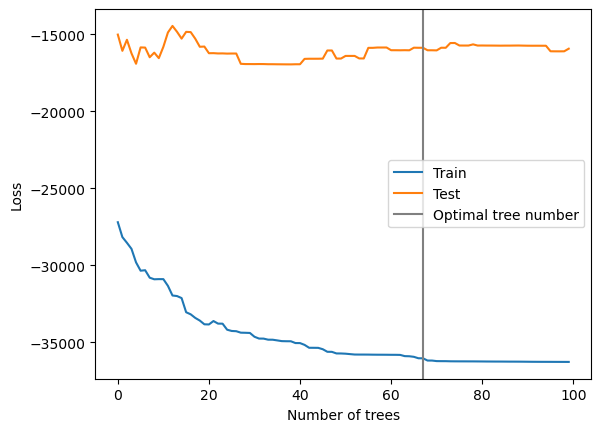

In [78]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.axvline(67, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

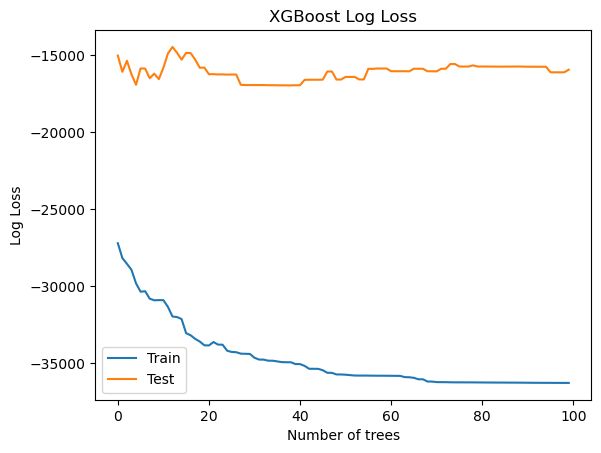

In [77]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.xlabel("Number of trees")
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

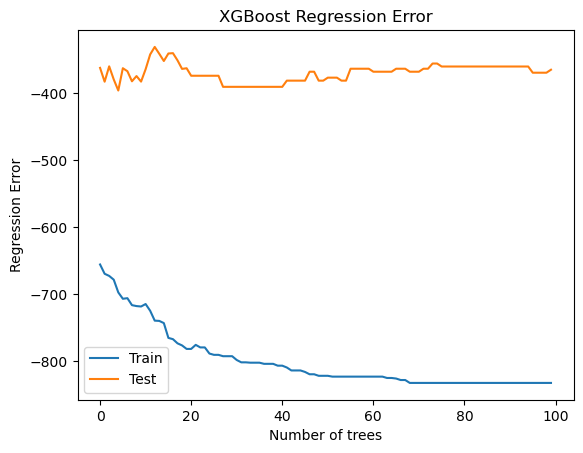

In [79]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
pyplot.xlabel("Number of trees")
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

In [81]:
# implemenmting early stopping to avoid overfitting
# early_stopping_rounds is not working here as it is already set up above
# 50 rounds for early stopping with 1000

#model_m2e.fit(x1_train, y1_train, eval_metric="logloss", eval_set=eval_set, verbose=True) #peaks at run 15
#model_m2e.fit(x1_train, y1_train, eval_metric="logloss", eval_set=eval_set, verbose=True) #peaks at run 15


#### Predictions
Now let's see how well the models can predict when given new data.

In [38]:
# fit a final xgboost model on the housing dataset and make a prediction
#from numpy import asarray
#from numpy import nan

# define model
#model = XGBRegressor()

# fit model
#model_m2e.fit(X1, y1, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False) # early_stopping_rounds=10

# define new data
#row = [63.0, 16.5, 68.8, 0, 360, 1008, 1.0, 1.0, 0.0, 0.0, ]
#row =[1,nan,nan,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[nan,1,nan,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[nan,nan,1,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[73.82,63.79,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#new_data = asarray([row])

# make a prediction
#yhat = model_m2e.predict(new_data)

# summarize prediction
#print('Predicted: %.3f' % yhat) # Predicted: 532.376, 574.485, Predicted: 576.899, Fire Predicted: -316.809; Harvest Predicted: -370.450


In [84]:
# Predict using test data set
# early_stopping_rounds=10 already implemented above no need to run here

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model_m2e.fit(x1_train, y1_train,  eval_metric="logloss", eval_set=eval_set, verbose=False)
#model_m2e.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=False)

ypred = model_m2e.predict(x1_test)
mse = mean_squared_error(y1_test, ypred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

#MSE: 243906.16
#RMSE: 493.87

# with model_m2e
#MSE: 726104.46
#RMSE: 852.12

#MSE: 702551.96
#RMSE: 838.18

#MSE: 509069.60
#RMSE: 713.49
#R-sq: 0.13

#MSE: 566205.78
#RMSE: 752.47
#R-sq: 0.03





MSE: 579805.08
RMSE: 761.45
R-sq: 0.01


C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


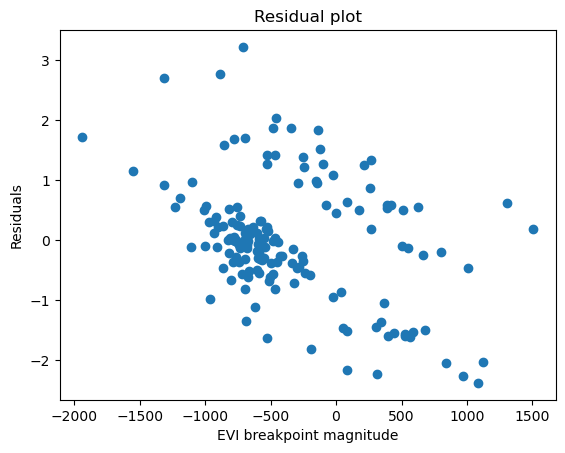

In [85]:
# Model prediction residuals

residuals = y1_test-ypred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(ypred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')

pyplot.show()

#### Model accuracy

Given that there are no classes when running regression algoriths, you shouldn't calculate accuracy metrics as when using classification algorithms. Instead, you should calculate errors like mean squared error. (see Jason B. reference)

#### Model plots

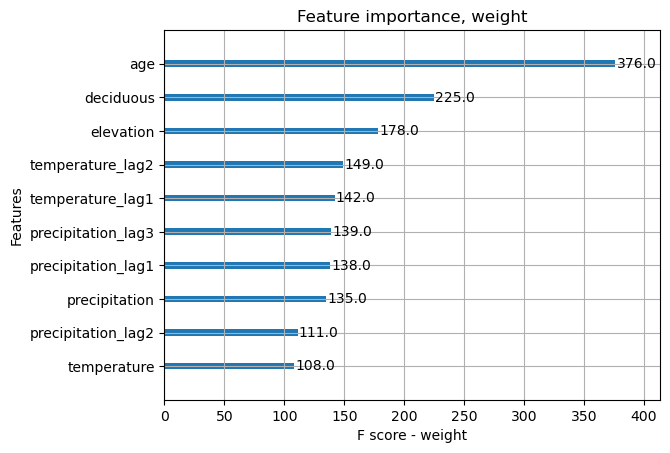

In [86]:
# Plot, metric: weight
#import xgboost as xgb
#import matplotlib.pyplot as plt

#xgb.plot_importance(model_m2c, max_num_features=10) # metric=weight is the default
#plt.show()

model_m2e = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric="logloss", feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)

#model_m2e.fit(x1_train, y1_train, eval_metric="logloss", eval_set=eval_set, verbose=False)
model_m2e.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)


xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, weight', 
                    xlabel='F score - weight', ylabel='Features', 
                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

pyplot.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.

# F score: This is a metric that simply sums up how many times each feature is split on




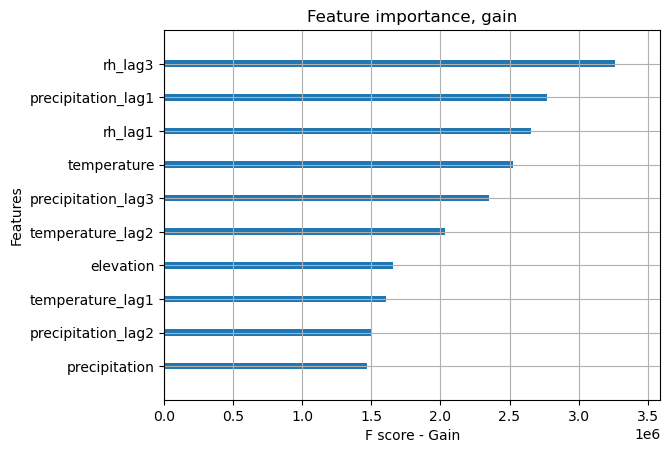

In [87]:
# Plot, metric: gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig('gain5.png',  dpi=300, bbox_inches='tight')


pyplot.show()

In [96]:
# Alternate way of plotting
# Plot, metric: weight
#feature_importance_weight = model_m2c.get_booster().get_score(importance_type='weight')
#keys = list(feature_importance_weight.keys())
#values = list(feature_importance_weight.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 40 features

#data.head()


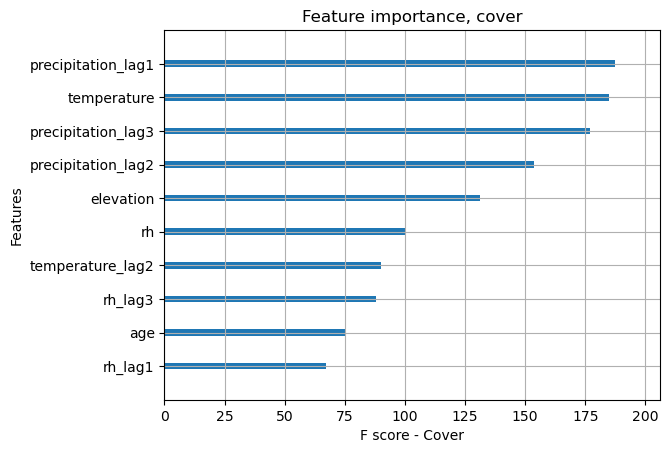

In [88]:
# Plot, metric: cover
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, cover', 
                    xlabel='F score - Cover', ylabel='Features', 
                    importance_type='cover', max_num_features=10, grid=True, show_values=False)

pyplot.show()


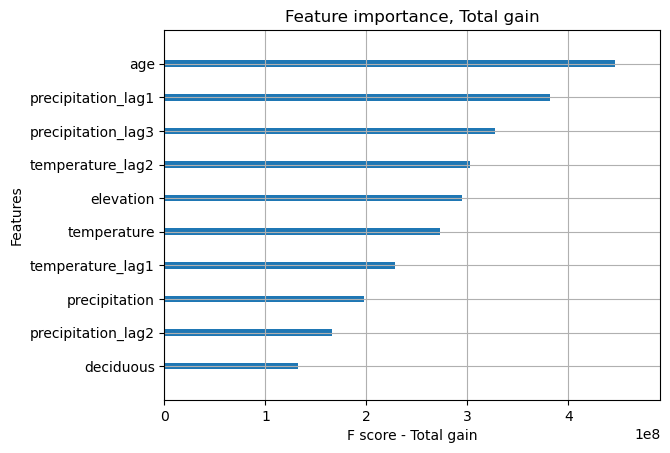

In [89]:
# Plot, metric: total gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total gain', 
                    xlabel='F score - Total gain', ylabel='Features', 
                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

pyplot.savefig('total_gain5.png',  dpi=300, bbox_inches='tight')

pyplot.show()

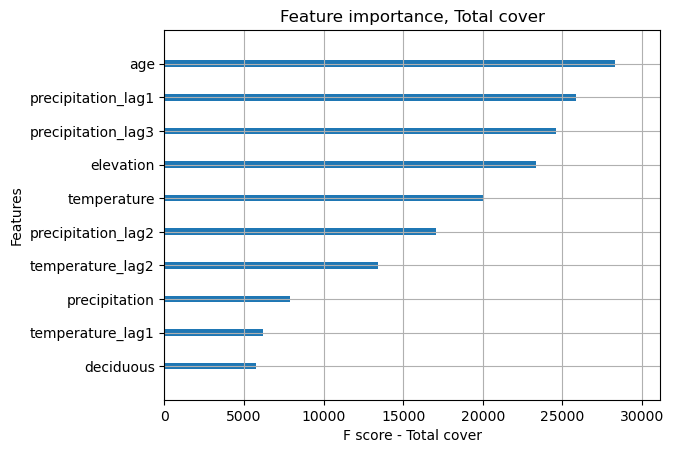

In [90]:
# Plot, metric: total cover
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total cover', 
                    xlabel='F score - Total cover', ylabel='Features', 
                    importance_type='total_cover', max_num_features=10, grid=True, show_values=False)

pyplot.show()

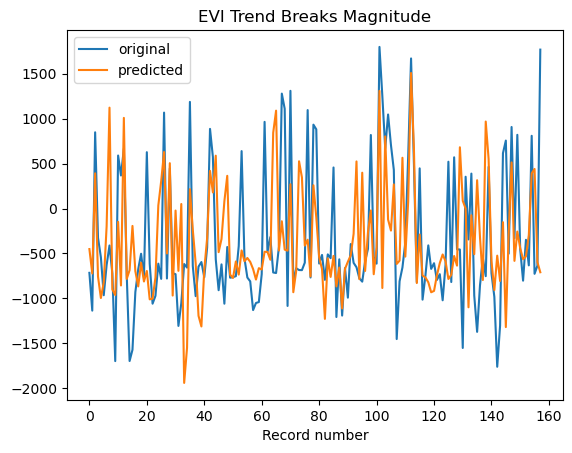

In [91]:
import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

plt.title("EVI Trend Breaks Magnitude")

plt.legend()

plt.savefig('original_vs_predicted5.png',  dpi=300, bbox_inches='tight')

plt.show()

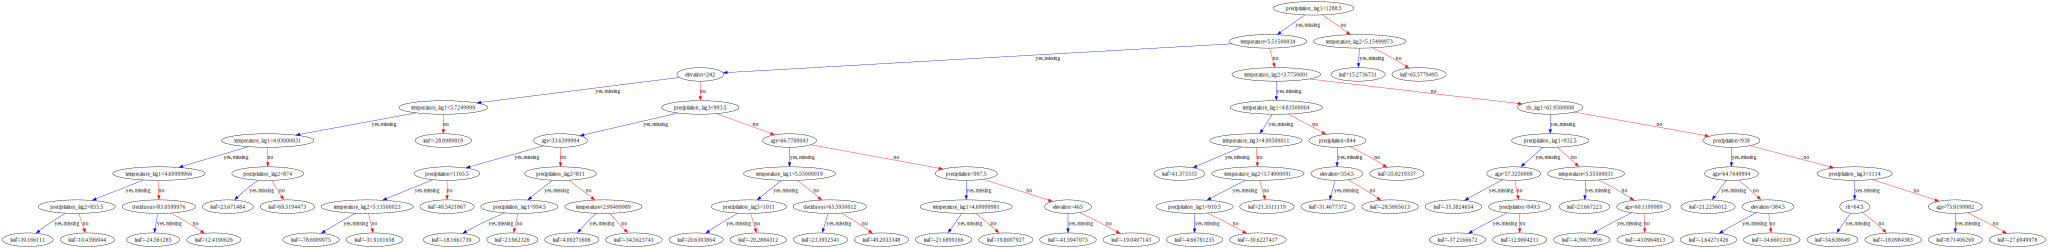

In [92]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

xgb.to_graphviz(model_m2e, num_trees = 1)


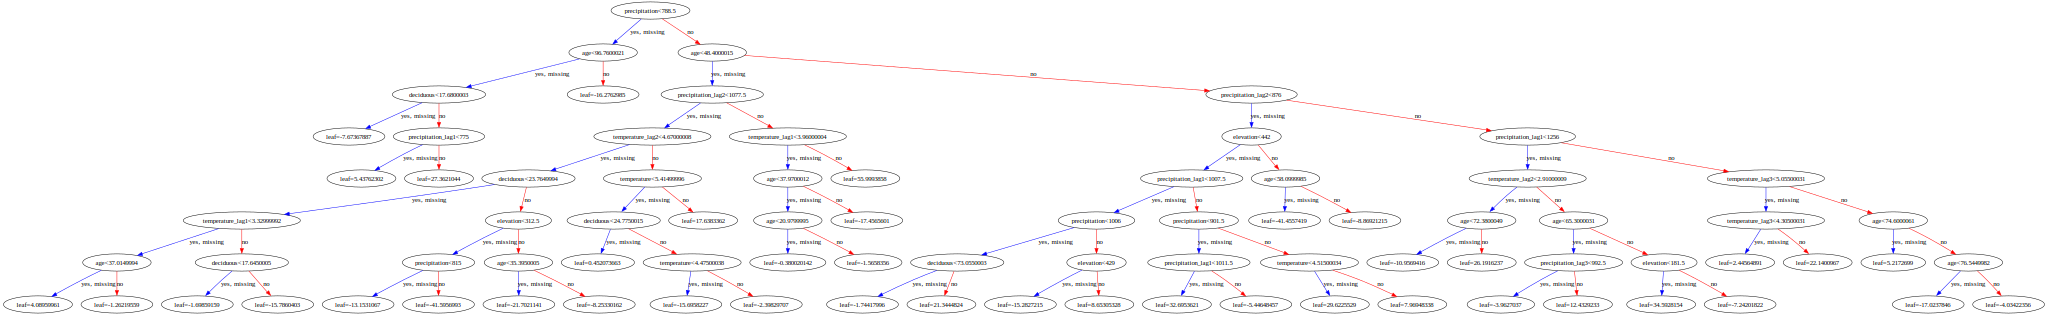

In [98]:
# Plot tree, Best iteration

xgb.to_graphviz(model_m2e, num_trees = model_m2e.best_iteration) #num_trees=xgb_model.best_iteration

#plt.savefig('decision_tree2.png',  dpi=300, bbox_inches='tight')

#plt.show()



In [93]:
# this works for saving graphviz
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_m2e, num_trees = model_m2e.best_iteration)

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render('decision_tree5', format = format)


'decision_tree5.png'

In [52]:
# More plots
from numpy import nan
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
#from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

#features_names1 = ["age",  "deciduous" , "conifers" , "elevation", "precipitation" , "temperature", "protected_0",  "driver_class_0" , "driver_class_1" , "driver_class_2"]
#features_names1 = ["fire","harvest","insects","age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
#features_names1 = ["age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3","protected_0","protected_1"]

target_names1 = "Magnitude"

# tree max is 61 after "stop early"
#tree_index=model_m2e.best_iteration
viz_rmodel = dtreeviz.model(model=model_m2e, tree_index=1, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)

viz_rmodel.view()



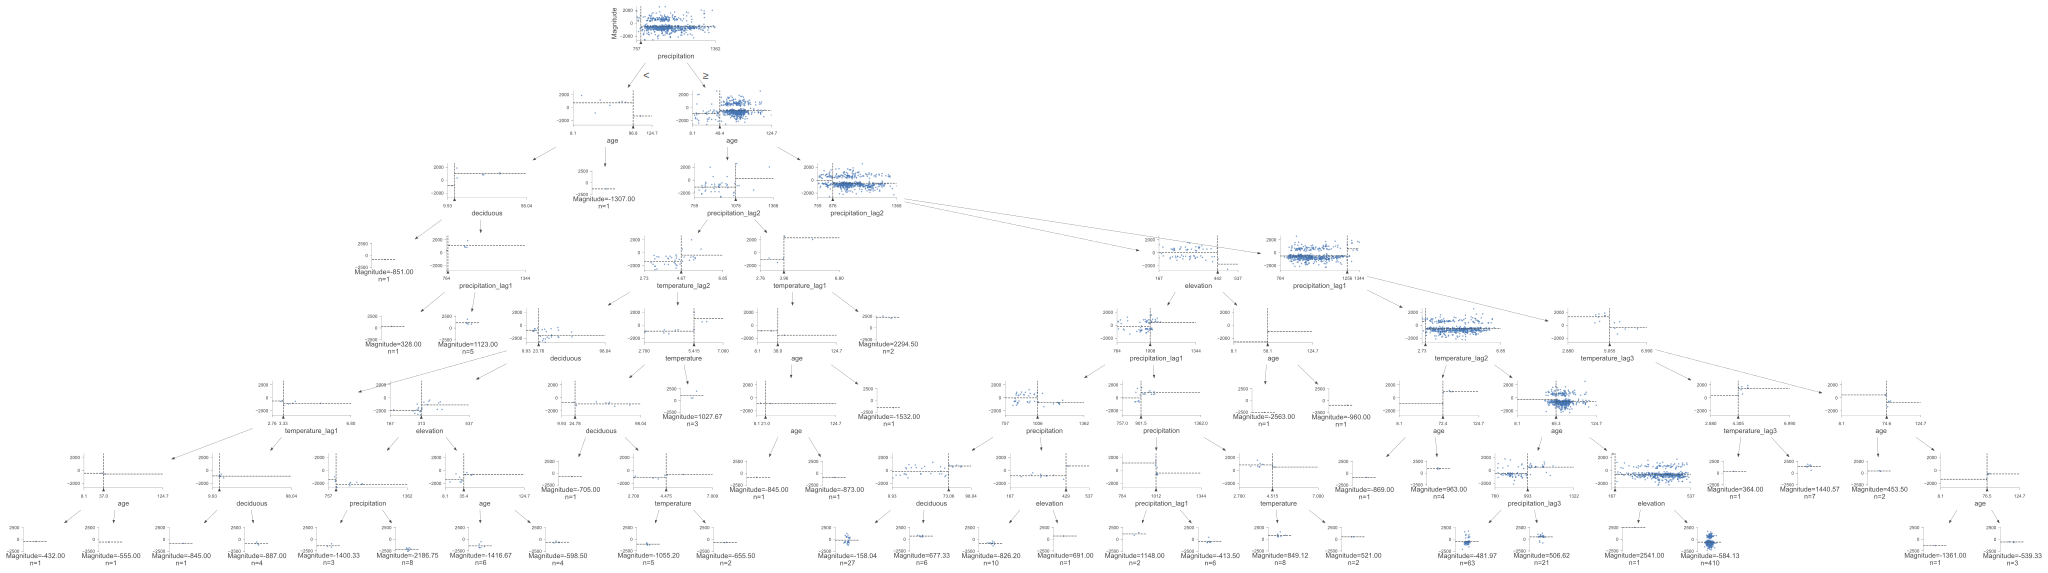

In [67]:
# More plots
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
#from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

#features_names1 = ["age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
#features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
target_names1 = "Magnitude"

# tree max is # after "stop early"
viz_rmodel = dtreeviz.model(model=model_m2e, tree_index=model_m2e.best_iteration, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)


viz_rmodel.view()

#v = viz_rmodel.view()     # render as SVG into internal object 
#v.show()                 # pop up window
#v.save("decision_tree_treeviz.svg")  # optionally save as svg

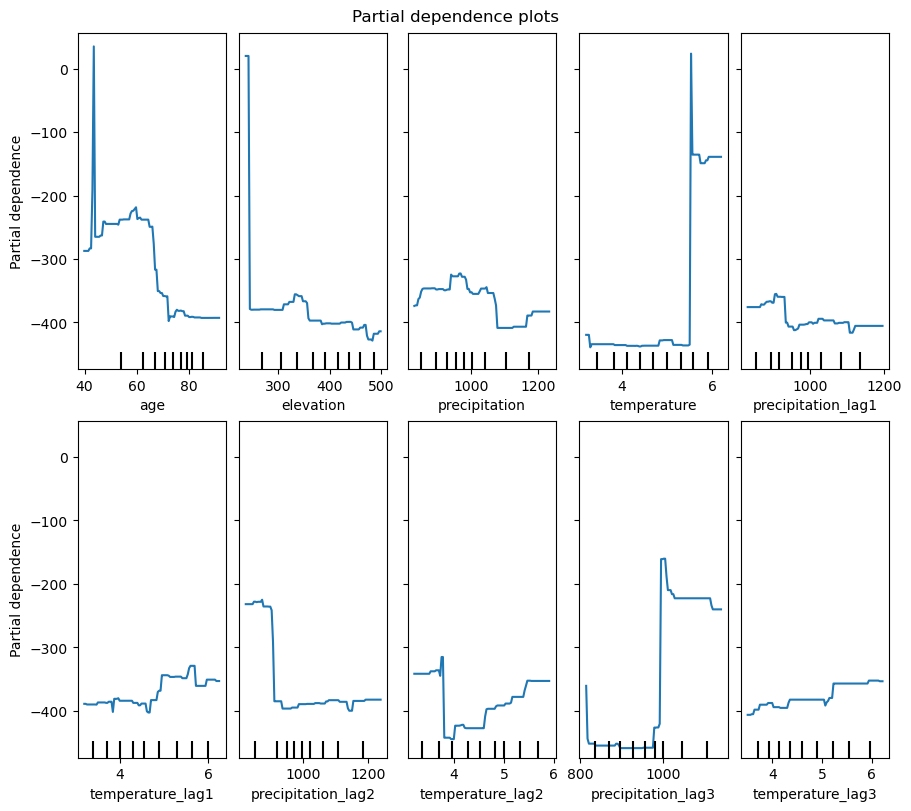

In [94]:
# Partial dependence plots
# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

features_names2 = ["age","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_m2e, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig('partial_dependence5.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles


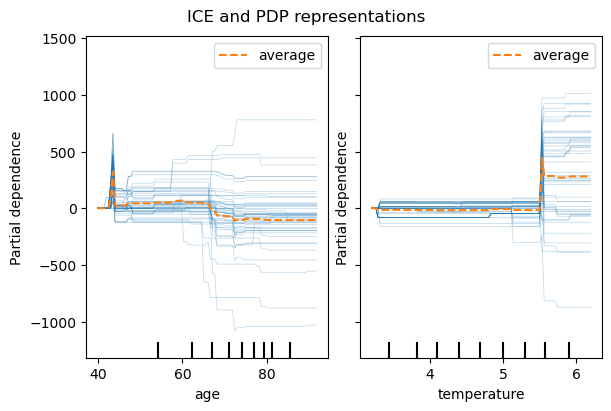

In [95]:
# Individual Effect Plot (ICE)
_, ax1 = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

common_params = {
    "subsample": 50,
    #"n_jobs": 2,
   # "grid_resolution": 20,
   # "random_state": 0,
}

features_info = {
    "features": ["age", "temperature"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    model_m2e,
    x1_train,
    **features_info,
    ax=ax1,
    **common_params,
)

_ = display.figure_.suptitle("ICE and PDP representations", fontsize=12)

In [97]:
# 2D interaction plots

#_, ax1 = plt.subplots(ncols=3, figsize=(6, 4), sharey=True, constrained_layout=True)

#common_params = {
#    "subsample": 50,
#    #"n_jobs": 2,
#   # "grid_resolution": 20,
#   # "random_state": 0,
#}

#features_info = {
#    "features": ["precipitation_lag3", "age",  ("precipitation_lag3", "age")],
#    #"kind": "both",
#    "kind": "average",
#    #"centered": True,
#}

#display = PartialDependenceDisplay.from_estimator(
#    model_m2e,
#    x1_train,
#    **features_info,
#    ax=ax1,
#   # **common_params,
#)

#_ = display.figure_.suptitle("2-way of numerical PDP", fontsize=12)


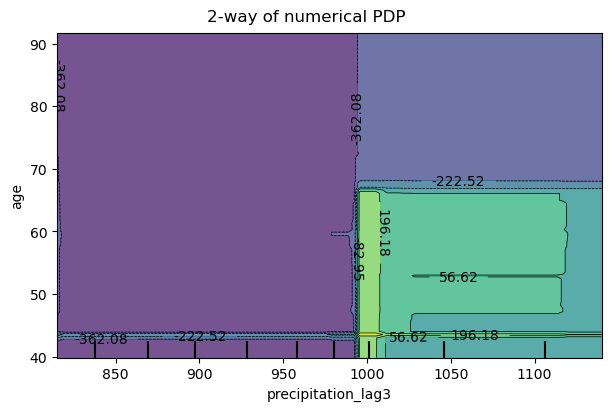

In [98]:
# 2D interaction plots
_, ax1 = plt.subplots(ncols=1, figsize=(6, 4), sharey=True, constrained_layout=True)

common_params = {
    "subsample": 50,
    #"n_jobs": 2,
   # "grid_resolution": 20,
   # "random_state": 0,
}

features_info = {
    "features": [ ("precipitation_lag3", "age")],
    #"kind": "both",
    "kind": "average",
    #"centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    model_m2e,
    x1_train,
    **features_info,
    ax=ax1,
   # **common_params,
)

_ = display.figure_.suptitle("2-way of numerical PDP", fontsize=12)

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


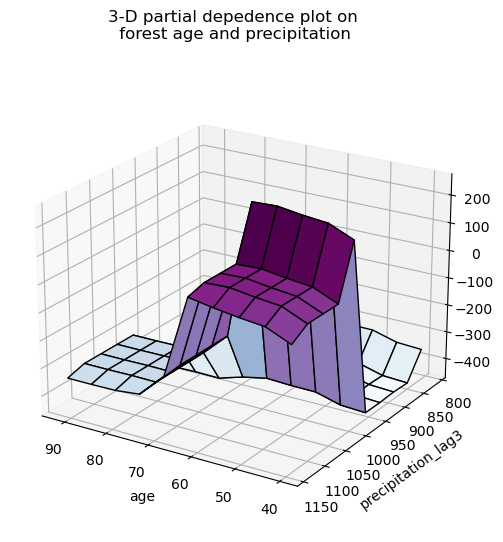

In [99]:
# 3D plot
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(6.5,6))

features = ("age", "precipitation_lag3")

pdp = partial_dependence(
    model_m2e,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n forest age and precipitation",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

plt.savefig('3d_partial_dependence5.png',  dpi=300, bbox_inches='tight')

plt.show()

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.


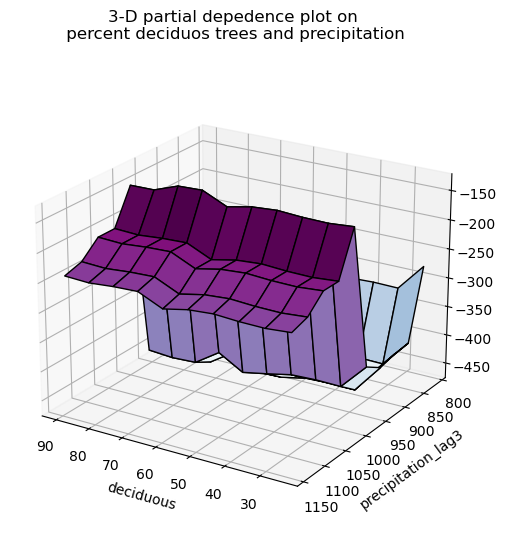

In [71]:
fig = plt.figure(figsize=(6.5,6))

features = ("deciduous", "precipitation_lag3")

pdp = partial_dependence(
    model_m2e,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n percent deciduos trees and precipitation",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

#plt.savefig('3d_partial_dependence2.png',  dpi=300, bbox_inches='tight')

plt.show()

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


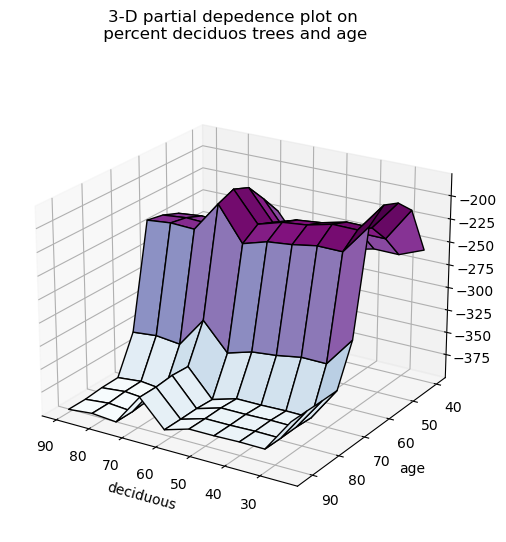

In [100]:
fig = plt.figure(figsize=(6.5,6))

features = ("deciduous", "age")

pdp = partial_dependence(
    model_m2e,
    x1_train, features=features, kind="average", grid_resolution=10
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1]) #"grid_values" in newer version of sklearn
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "3-D partial depedence plot on\n percent deciduos trees and age",
    fontsize=12,
)
# pretty init view
ax.view_init(elev=22, azim=122)
#clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#clb.ax.set_title("Partial\ndependence")

#plt.savefig('3d_partial_dependence2.png',  dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# save in JSON format
#model.save_model("model_regression1.json")
# save in text format
#model_m2.save_model("model_m2.txt")


In [ ]:
# load saved model
#model2 = xgb.Regressor()
#model2.load_model("model_regression1.json")


#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

https://scikit-learn.org/stable/modules/partial_dependence.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#way-partial-dependence-with-different-models

https://mljar.com/blog/xgboost-early-stopping/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://github.com/parrt/dtreeviz



